CS524: Introduction to Optimization Lecture 23
======================================

## Michael Ferris<br> Computer Sciences Department <br> University of Wisconsin-Madison

## October 27, 2023
--------------

# Travel Salesman Problem (TSP)
This is the most famous combinatorial optimization problem. A traveling salesman would visit all his cities, starting and ending in the same city, at the minimum cost.

Data is simple:
- A set of cities $N$
- Distances between cities $c_{ij}$ to determine travel costs between them

There are lots of applications such as in chip design. In chip design, we would like to find a route going through all of components on a chip to make them connected at a minimum cost.

Here we use variable $x_{ij}$ to indicate if use route leg i-j.

$$x_{ij}= \left\{\begin{matrix}
 1& travel\hspace{0.1cm}from\hspace{0.1cm}city\hspace{0.1cm}i\hspace{0.1cm}to\hspace{0.1cm}city\hspace{0.1cm}j \\ 
 0& otherwise
\end{matrix}\right. $$

# A Formulation of TSP 
First consider the following formulation:

$$\min \sum_{i\in N}^{ }\sum_{j\in N}^{ }c_{ij}x_{ij}$$

$$\sum_{i\in N}^{ }x_{ij}=1, \forall j \in N\hspace{2cm}  (1)$$
$$\sum_{j\in N}^{ }x_{ij}=1, \forall i \in N\hspace{2cm}  (2)$$
$$x_{ij} \in \{0,1\}$$


- Equation $(1)$ implies that every city $j$ has exactly one predecessor city.
- Equation $(2)$ implies that every city $i$ has exactly one successor city.

It is the current formulation, which is a mixed linear programming problem. However, is this a valid TSP formulation? Let's discuss in the following!

The following visualization uses **geopandas** to visualize the map of USA and look up the longtitude and latitude of every city in this problem. Extracting the "tour" variable from GAMS, we can show the routing result in the map.

### Visualize routes by geopandas

In [1]:
# Uncomment the following line if you don't have geopandas installed
# pip install geopandas

In [2]:
import geopandas
import matplotlib.pyplot as plt
%matplotlib inline

# load the world map and extract the map of United States of America
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
us = world[(world.pop_est>0) & (world.name=="United States of America")]

# create a dictionary to map city names to their geological information
city = dict()
city['Atlanta']      = [ -84.387985, 33.748997]
city['Chicago']      = [ -87.629799, 41.878113]
city['Denver']       = [-104.990250, 39.739235]
city['Houston']      = [ -95.369804, 29.760427]
city['LosAngeles']   = [-118.243683, 34.052235]
city['Madison']      = [ -89.401230, 43.073051]
city['NewYork']      = [ -74.005974, 40.712776]
city['SanFrancisco'] = [-122.419418, 37.774929]
city['Seattle']      = [-122.332069, 47.606209]
city['WashingtonDC'] = [ -77.036873, 38.907192]
city['Miami']        = [ -80.191788, 25.761681]

# the main function to visualize routes
def plot_with_tour(tour):
    tour.columns = ['from','to']
    us.plot(figsize=(20,20),color='white', edgecolor='black')
    for k, v in city.items():
        plt.scatter(*v, c='black',alpha=0.5)
        plt.text(*v, k)
    for index, row in tour.iterrows():
        st = city[row['from']]
        ed = city[row['to']] 
        plt.plot([st[0],ed[0]], [st[1],ed[1]], 'r-')
    plt.xlim(-130,-60)
    plt.ylim(23,53)

/var/folders/zw/wp74l5d542vcmkdl6jy41pzr0000gp/T/ipykernel_88172/1250283132.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


To graph the route taken between cities, just call method **plot_with_tour()**

In [3]:
%load_ext gams.magic
m = gams.exchange_container

### TSP example

This is an 11 city example (including Madison)

In [4]:
%%gams
set city /  Atlanta,Chicago,Denver,Houston,LosAngeles,Madison,Miami,NewYork,SanFrancisco,Seattle,WashingtonDC /;
alias(city,i,j,k);

table      dist(i,j)      "distances"
            Atlanta Chicago   Denver Houston LosAngeles Madison Miami NewYork SanFrancisco Seattle WashingtonDC
Atlanta      0       587     1212    701       1936       700    604     748      2139       2182     543
Chicago      587      0      920     940       1745       122   1188     713      1858       1737     597
Denver       1212     920     0      879        831       839   1726    1631       949       1021    1494
Houston      701     940     879      0        1372       978    968    1420      1645       1891    1220
LosAngeles   1936    1745    831     1374        0        1670  2339    2451       347        959    2300
Madison      700     122     839      978      1670        0    1303     808       1764      1618     706
Miami        604    1188    1726     968       2339       1303    0      1092      2594       2734    923
NewYork      748     713    1631     1420      2451        808  1092     0        2571       2408    205
SanFrancisco 2139   1858    949     1645       347        1764  2594    2571        0         678    2442
Seattle      2182    1737   1021    1891       959        1618  2734    2408       678         0     2329
WashingtonDC  543    597    1494    1220      2300         706   923      205      2442        2329    0 ;

binary variables x(i,j);
free variable obj;

equations defobj, assign1(j), assign2(i);

defobj..
obj =e= sum((i,j), dist(i,j) * x(i,j));

assign1(j)..
sum(i$(not sameas(i,j)), x(i,j)) =e= 1;

assign2(i)..
sum(j$(not sameas(i,j)), x(i,j)) =e= 1;

x.fx(i,i) = 0;

set tour(i,i) ;
* Just print the tour in a simple way
option tour:0:0:1 ;

model tsp /defobj, assign1, assign2/;
solve tsp using mip min obj;
display obj.l;
tour(i,j)$(x.l(i,j) > 0.01) = yes ;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),5604.0,23,111,MIP,CPLEX,0.051


,i_0,i_1
0,Atlanta,Miami
1,Chicago,Madison
2,Denver,Houston
3,Houston,Denver
4,LosAngeles,Seattle
5,Madison,Chicago
6,Miami,Atlanta
7,NewYork,WashingtonDC
8,SanFrancisco,LosAngeles
9,Seattle,SanFrancisco


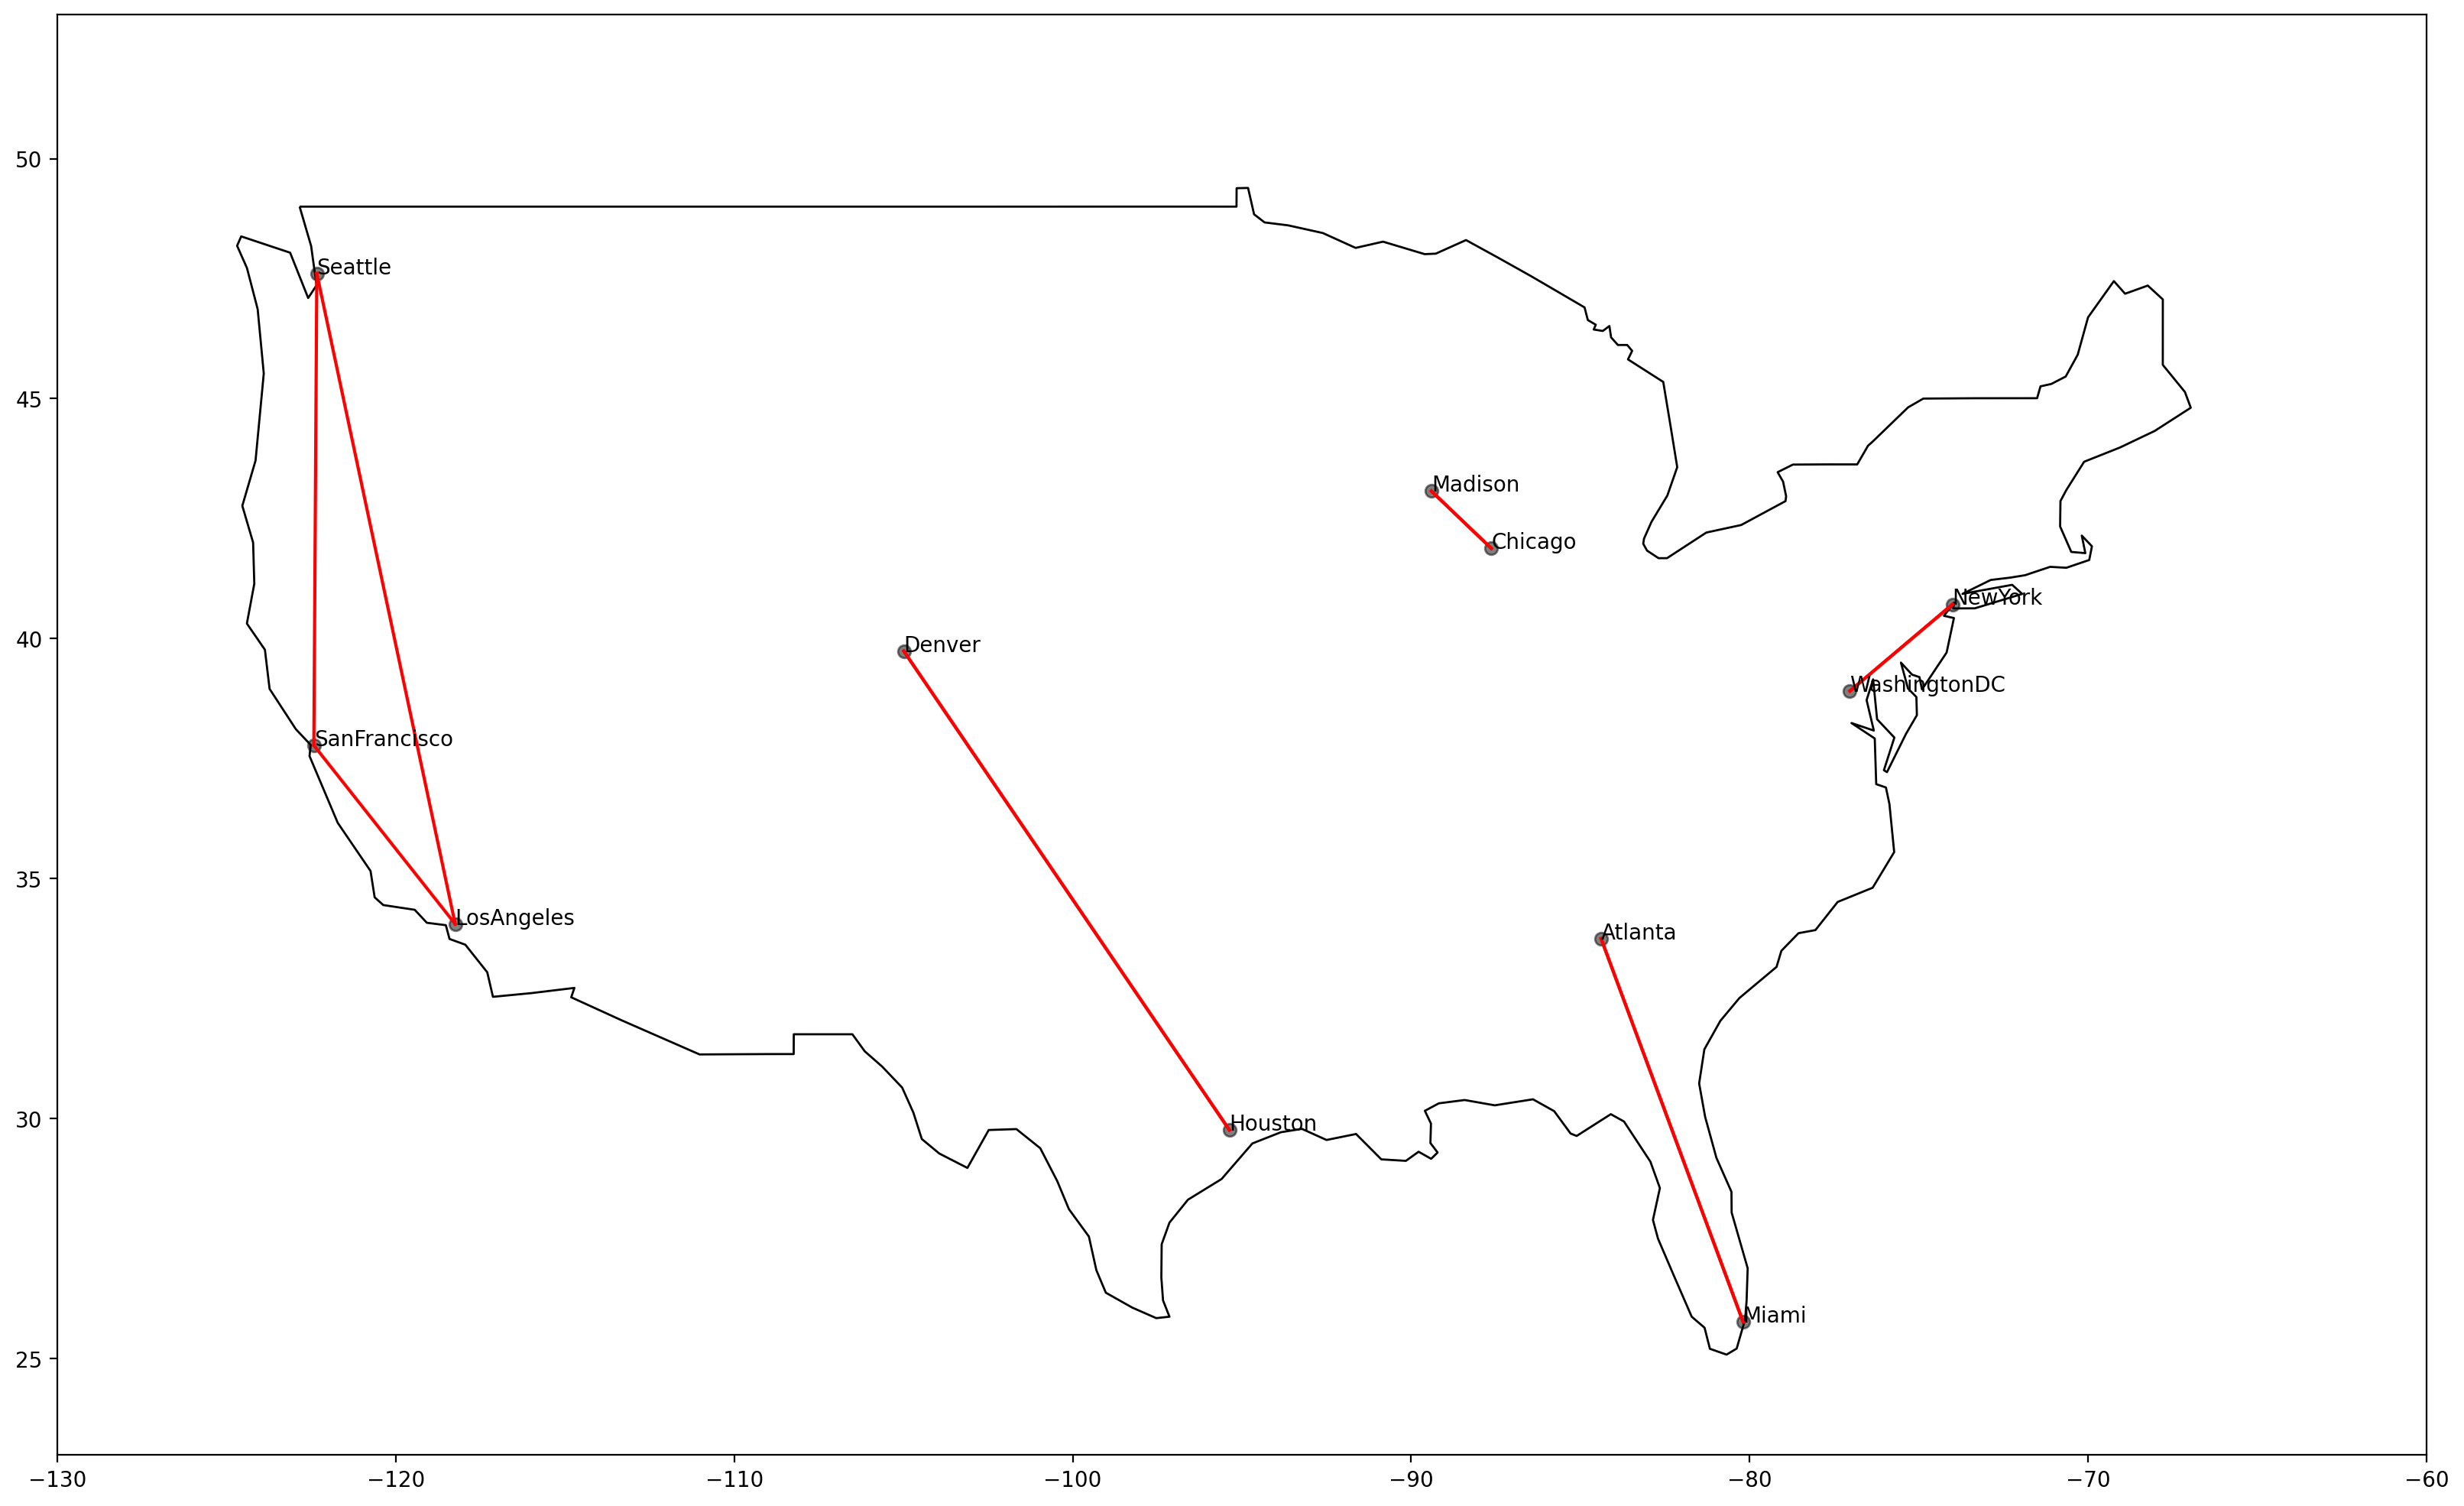

In [5]:
# throw away the "text" columns in dataframe
#tour.drop('element_text', axis=1, inplace=True)
#tour=m['tour'].records.iloc[:,0:2].copy()
t = m['tour']
tour = t.records[t.domain_labels].copy()
display(tour)

plot_with_tour(tour)

However, we found that the current formulation generates routes that form a loop between cities, such as Madison-Chicago and Chicago-Madison.

How do we get rid of those pesky subtours?
To avoid the routes only between **two** cities, we add the following constraint to eliminate simple loops.

Simple loop elimination

In [6]:
%%gams
equations simpleloop(i,j);

simpleloop(i,j)$(not sameas(i,j))..
  x(i,j) + x(j,i) =L= 1;

tour(i,j) = no ;
model tsp2 /defobj, assign1, assign2, simpleloop /;
solve tsp2 using mip minimizing obj ;
display obj.l;
tour(i,j)$(x.l(i,j) > 0.01) = yes ;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),6857.0,133,111,MIP,CPLEX,0.01


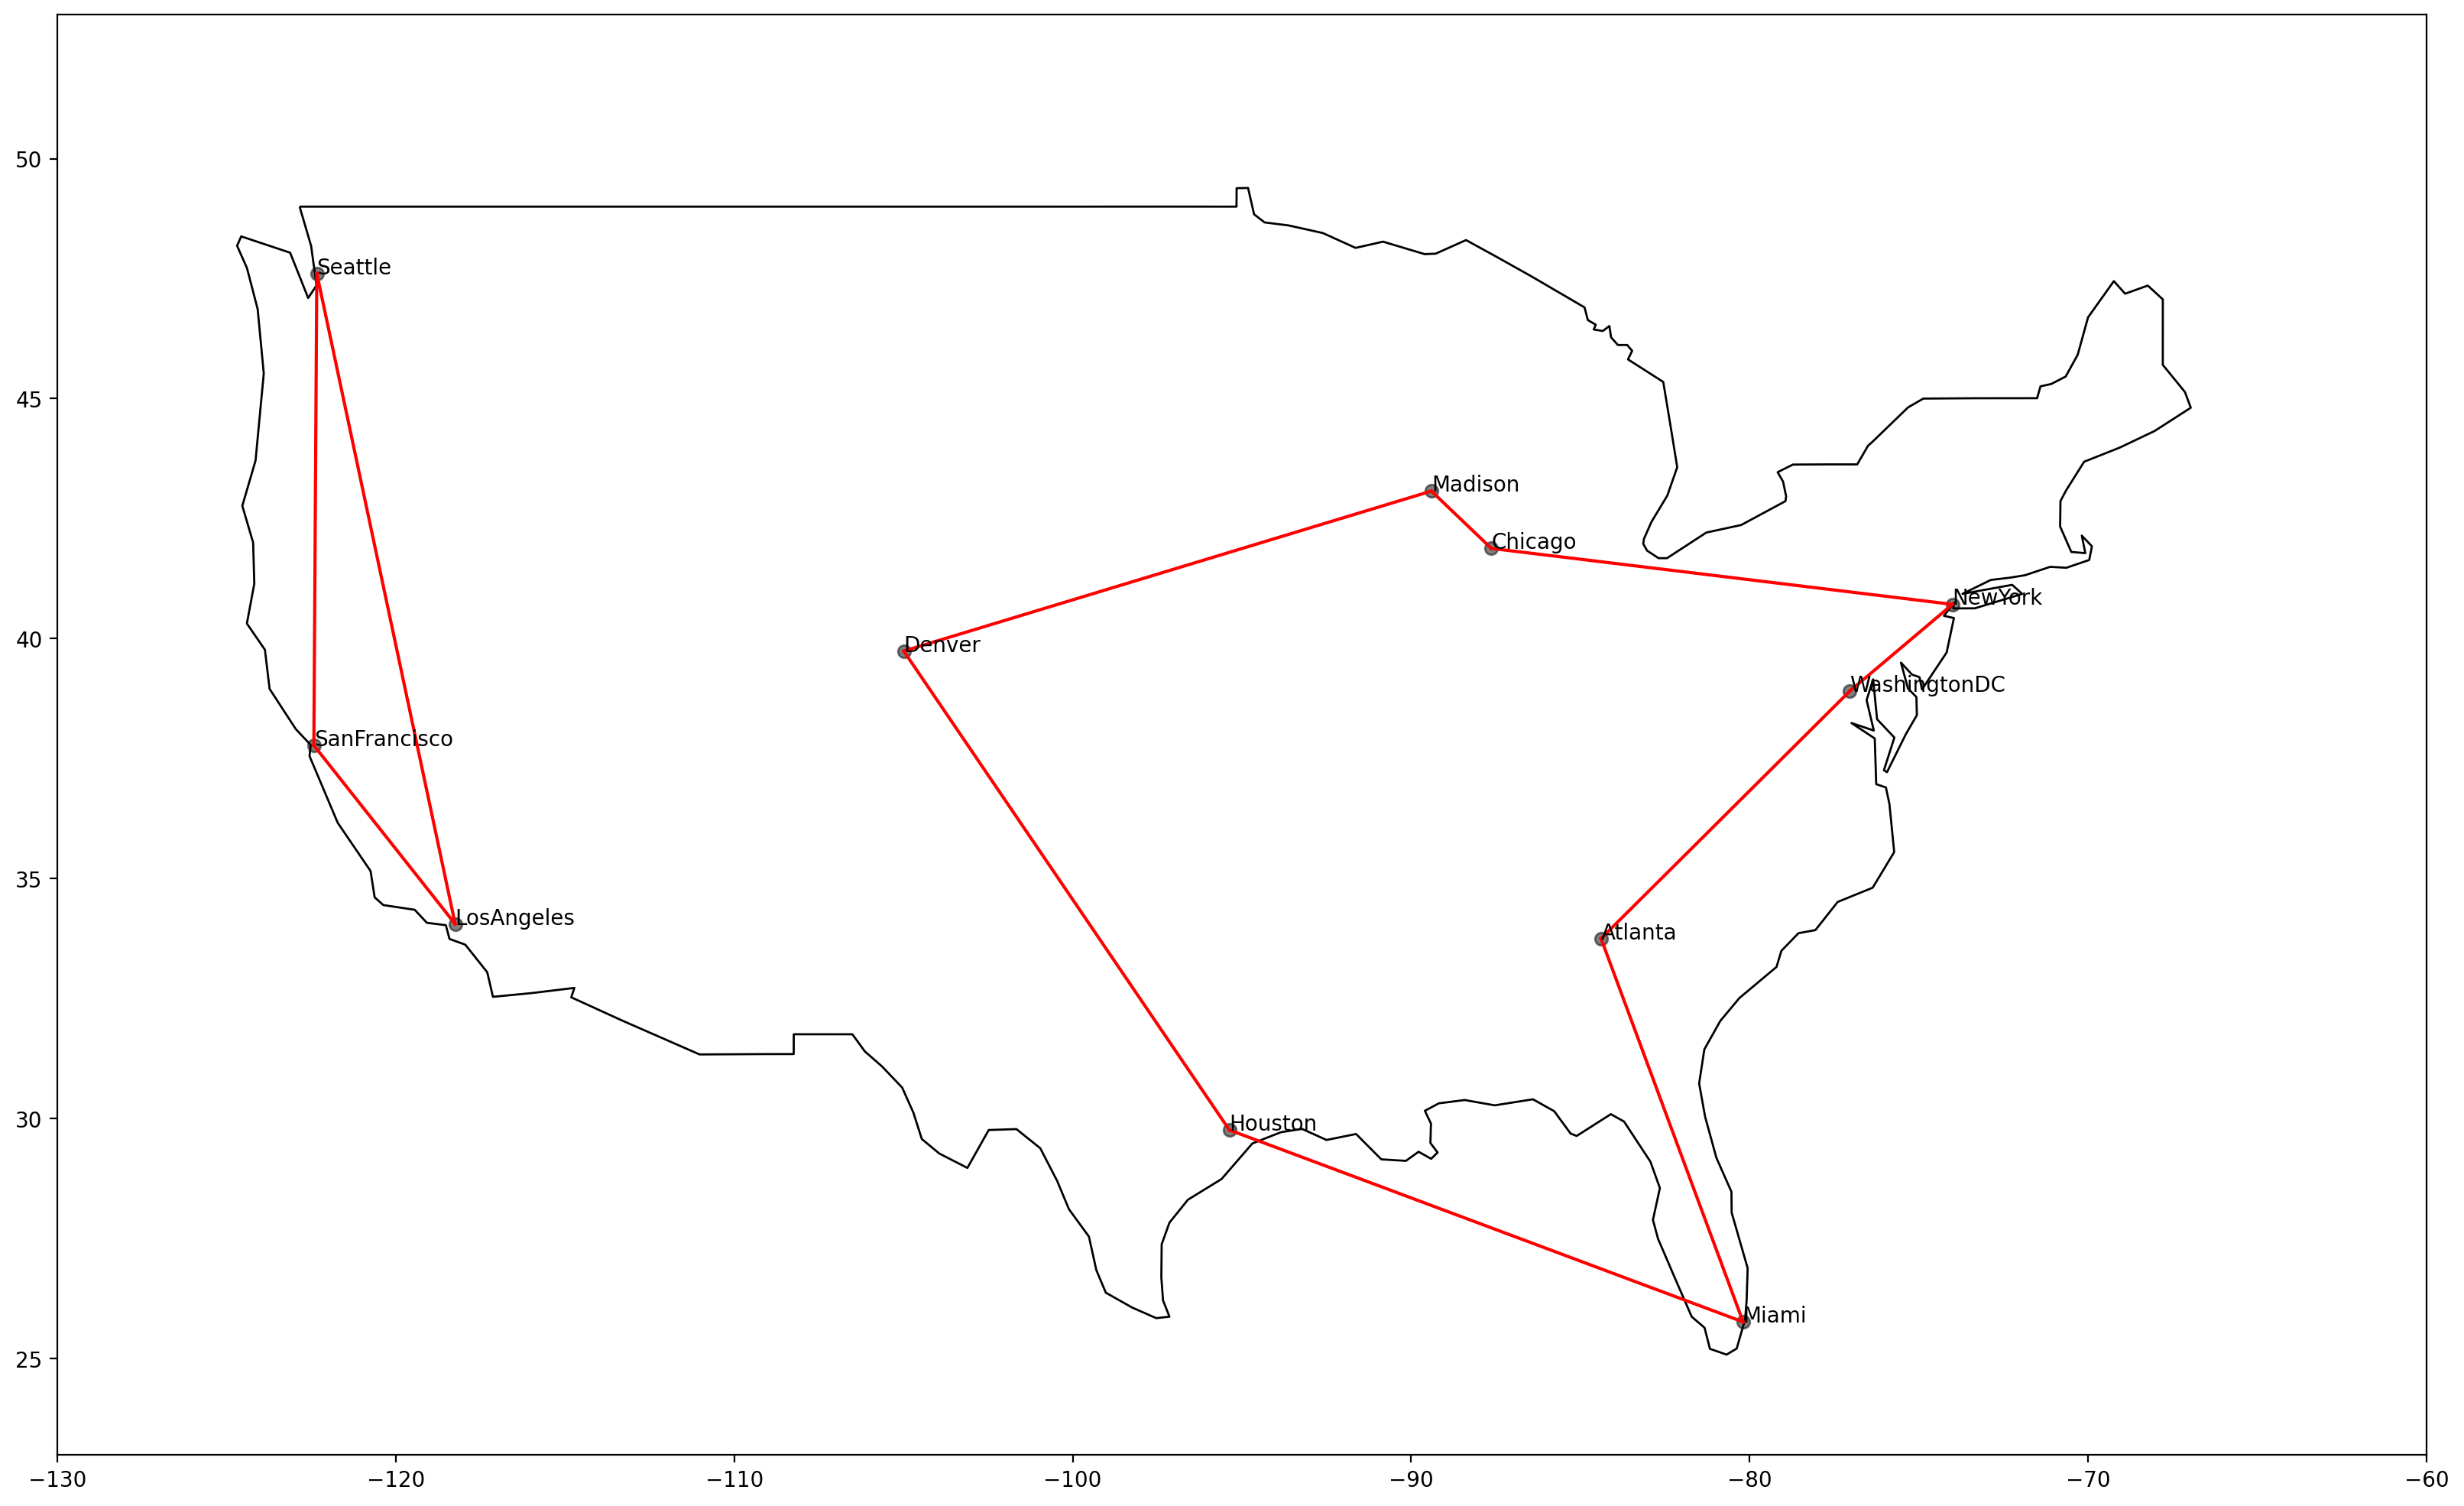

In [7]:
tour = t.records[t.domain_labels].copy()
plot_with_tour(tour)

Add triangles

In [8]:
%%gams
equations triangle(i,j,k);

triangle(i,j,k)..
  x(i,j) + x(i,k) + x(j,k) + x(j,i) + x(k,i) + x(k,j) =L= 2 ;

tour(i,j) = no ;
model tsp3 /defobj, assign1, assign2, simpleloop, triangle /;
solve tsp3 using mip minimizing obj ;
display obj.l;
tour(i,j)$(x.l(i,j) > 0.01) = yes ;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),7010.0,1464,122,MIP,CPLEX,0.013


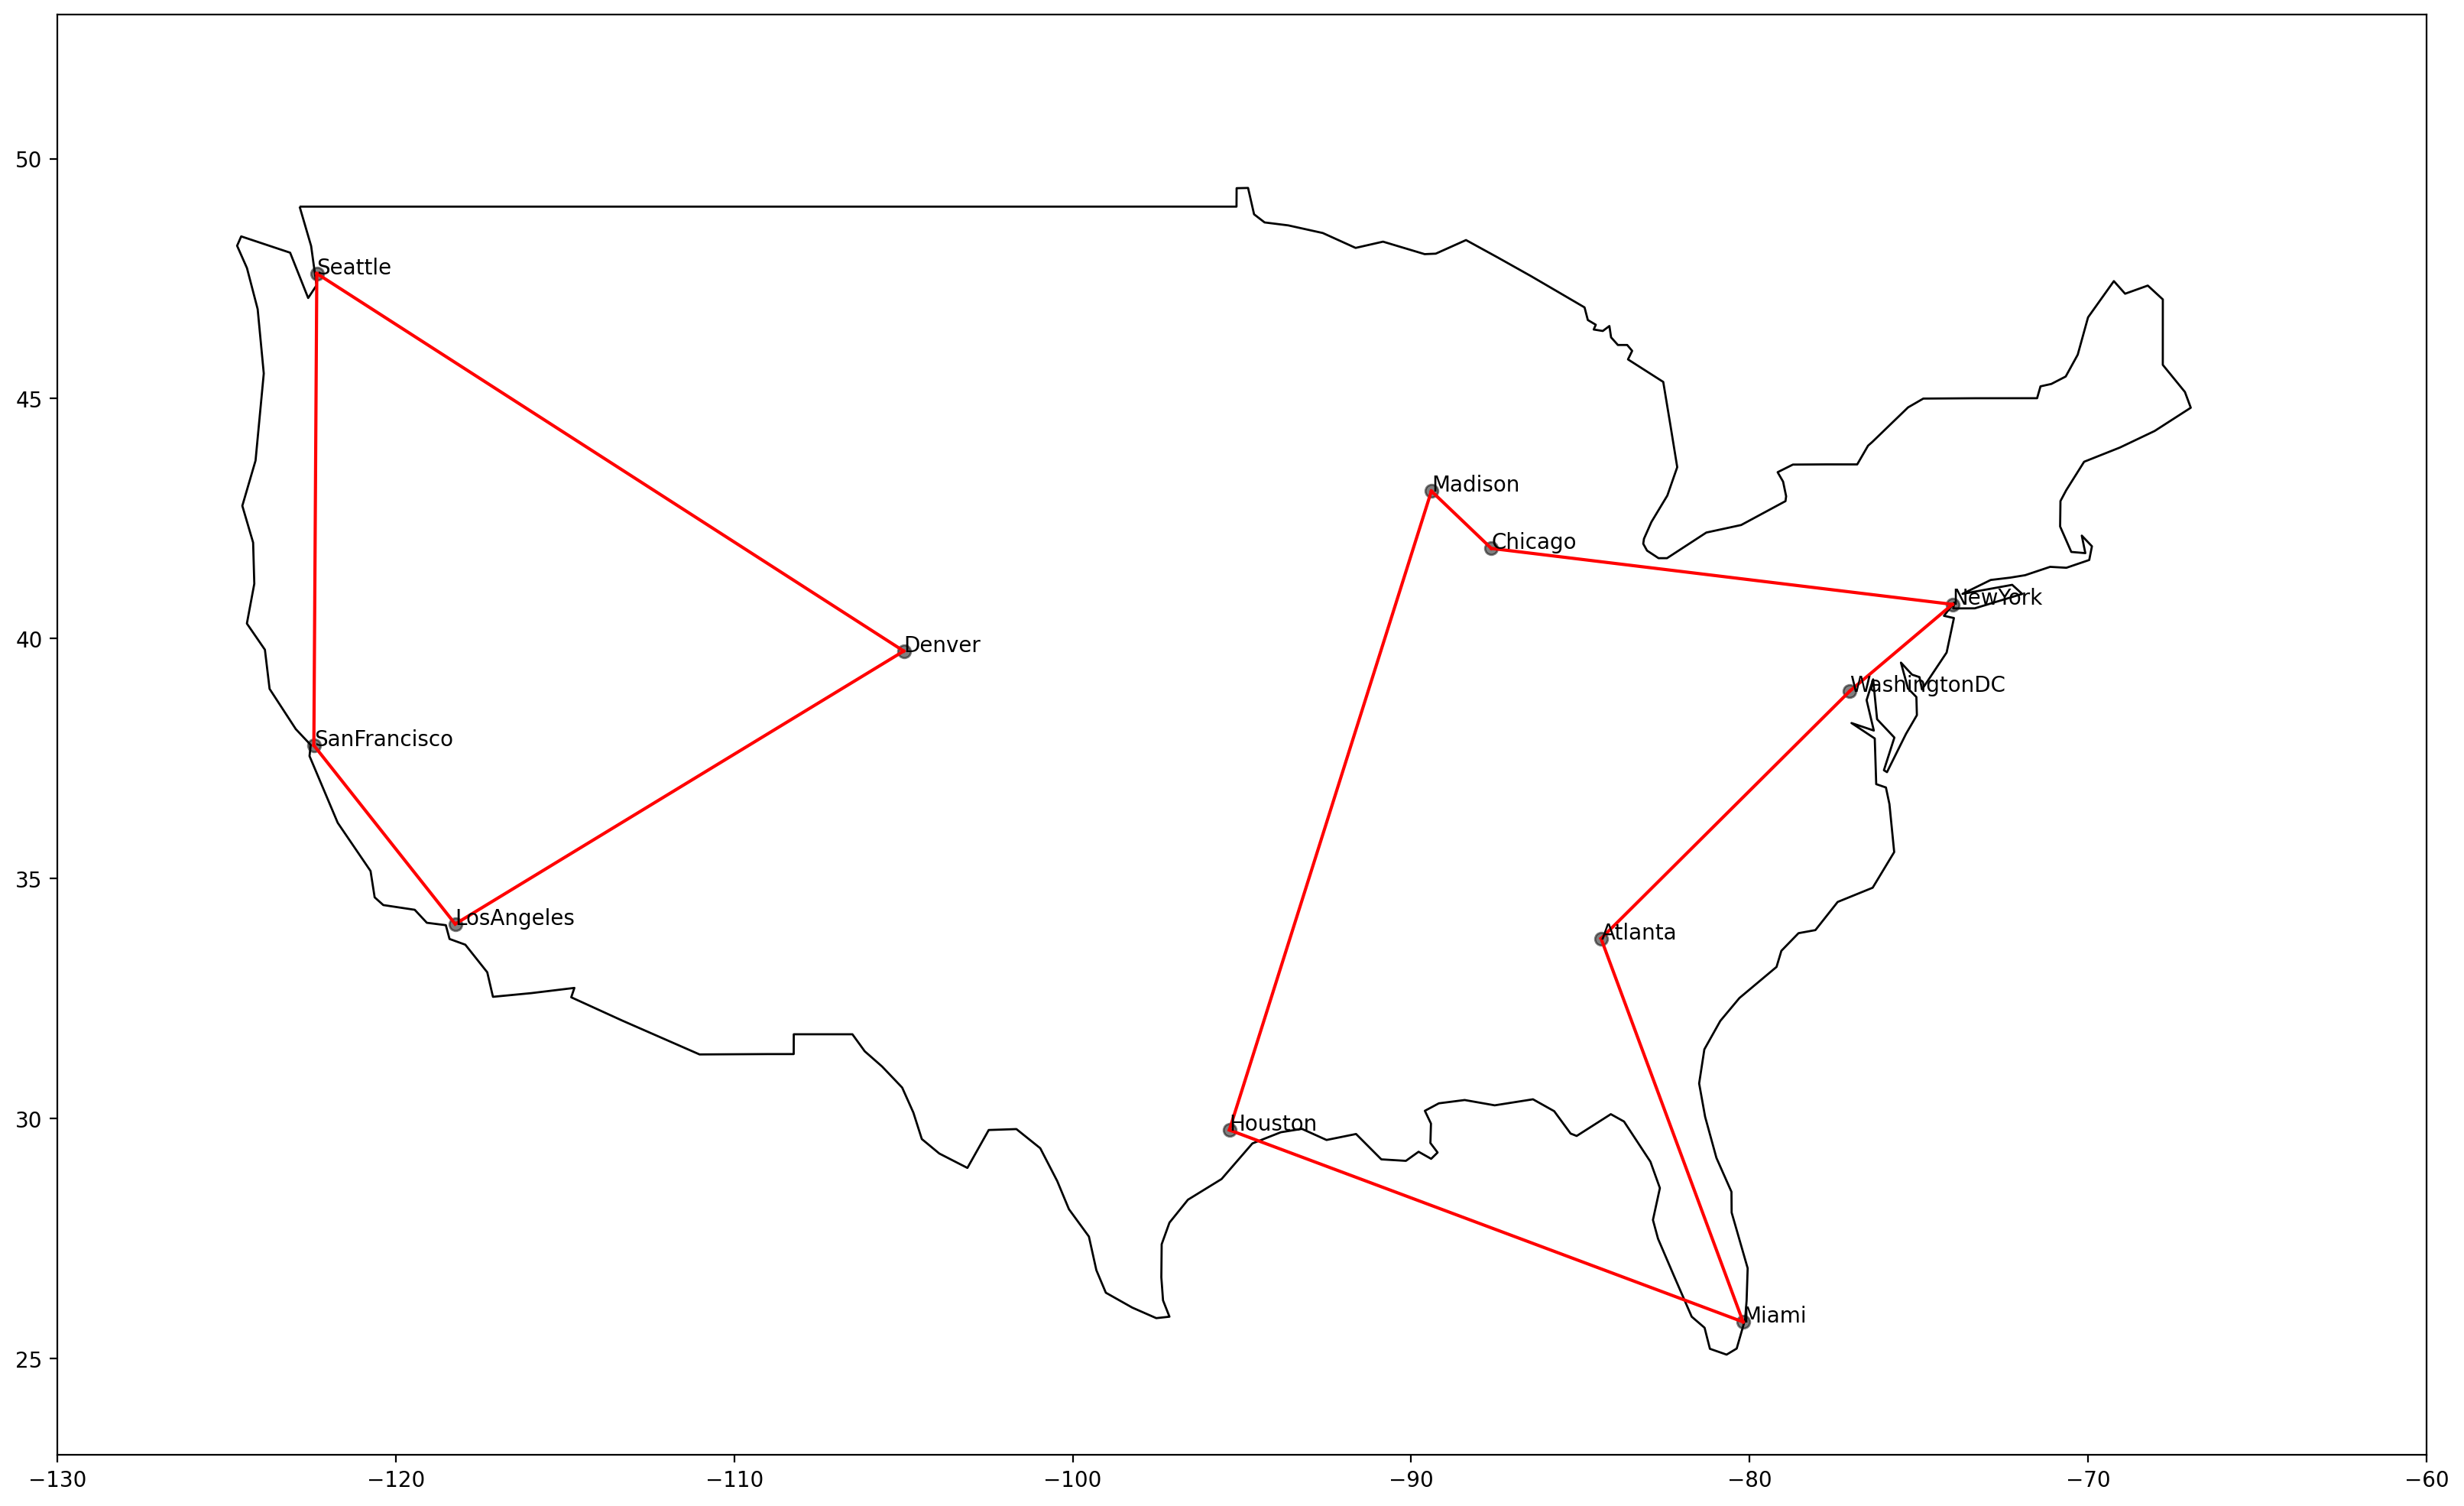

In [9]:
tour = t.records[t.domain_labels].copy()
plot_with_tour(tour)

Unfortunately, we still have routes with loops even after adding the triangle constraint. It's complicated to add constraints case by case and the number of constraints grow exponentially (23 -> 133 -> 1464).

## Quiz

1018517988167243043134222844204689080525734196832968125318070224677190649881668353091698688.

Is this...

- (a) The number of gifts that I have bought my wife?

- (b) The number of subatomic particles in the universe?

- (c) The number of “subtour elimination constraints” when |N | = 299.

- (d) All of the above?

- (e) None of the above?

## Answer: (e)

The answer is (e). (a)–(c) are all too small.

- Answer is almost (c) but $|N| = 300$

- “Exponential” is really big

Thus, we pursue an alternative to the subtour elimination constraints proposed by Pataki's paper in SIAM to remove all possible loops.

Add Miller-Tucker-Zemlin subtour elimination constraints (See Pataki Teaching IP paper in SIAM)

In [10]:
%%gams
positive variables u(i) ;
equations mtz(i,j);

mtz(i,j)$(ord(i) ne 1 and ord(j) ne 1)..
  u(i) - u(j) + 1 =L= (card(i) - 1) * (1 - x(i,j)) ;

model tsp4 /defobj, assign1, assign2, mtz/;

u.lo(i) = 2; u.up(i) = card(i);
u.fx(i)$(i.ord eq 1) = 1;

option optcr = 0;

solve tsp4 using mip minimizing obj ;
display obj.l;
tour(i,j) = no;
tour(i,j)$(x.l(i,j) > 0.01) = yes ;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),7412.0,123,131,MIP,CPLEX,0.057


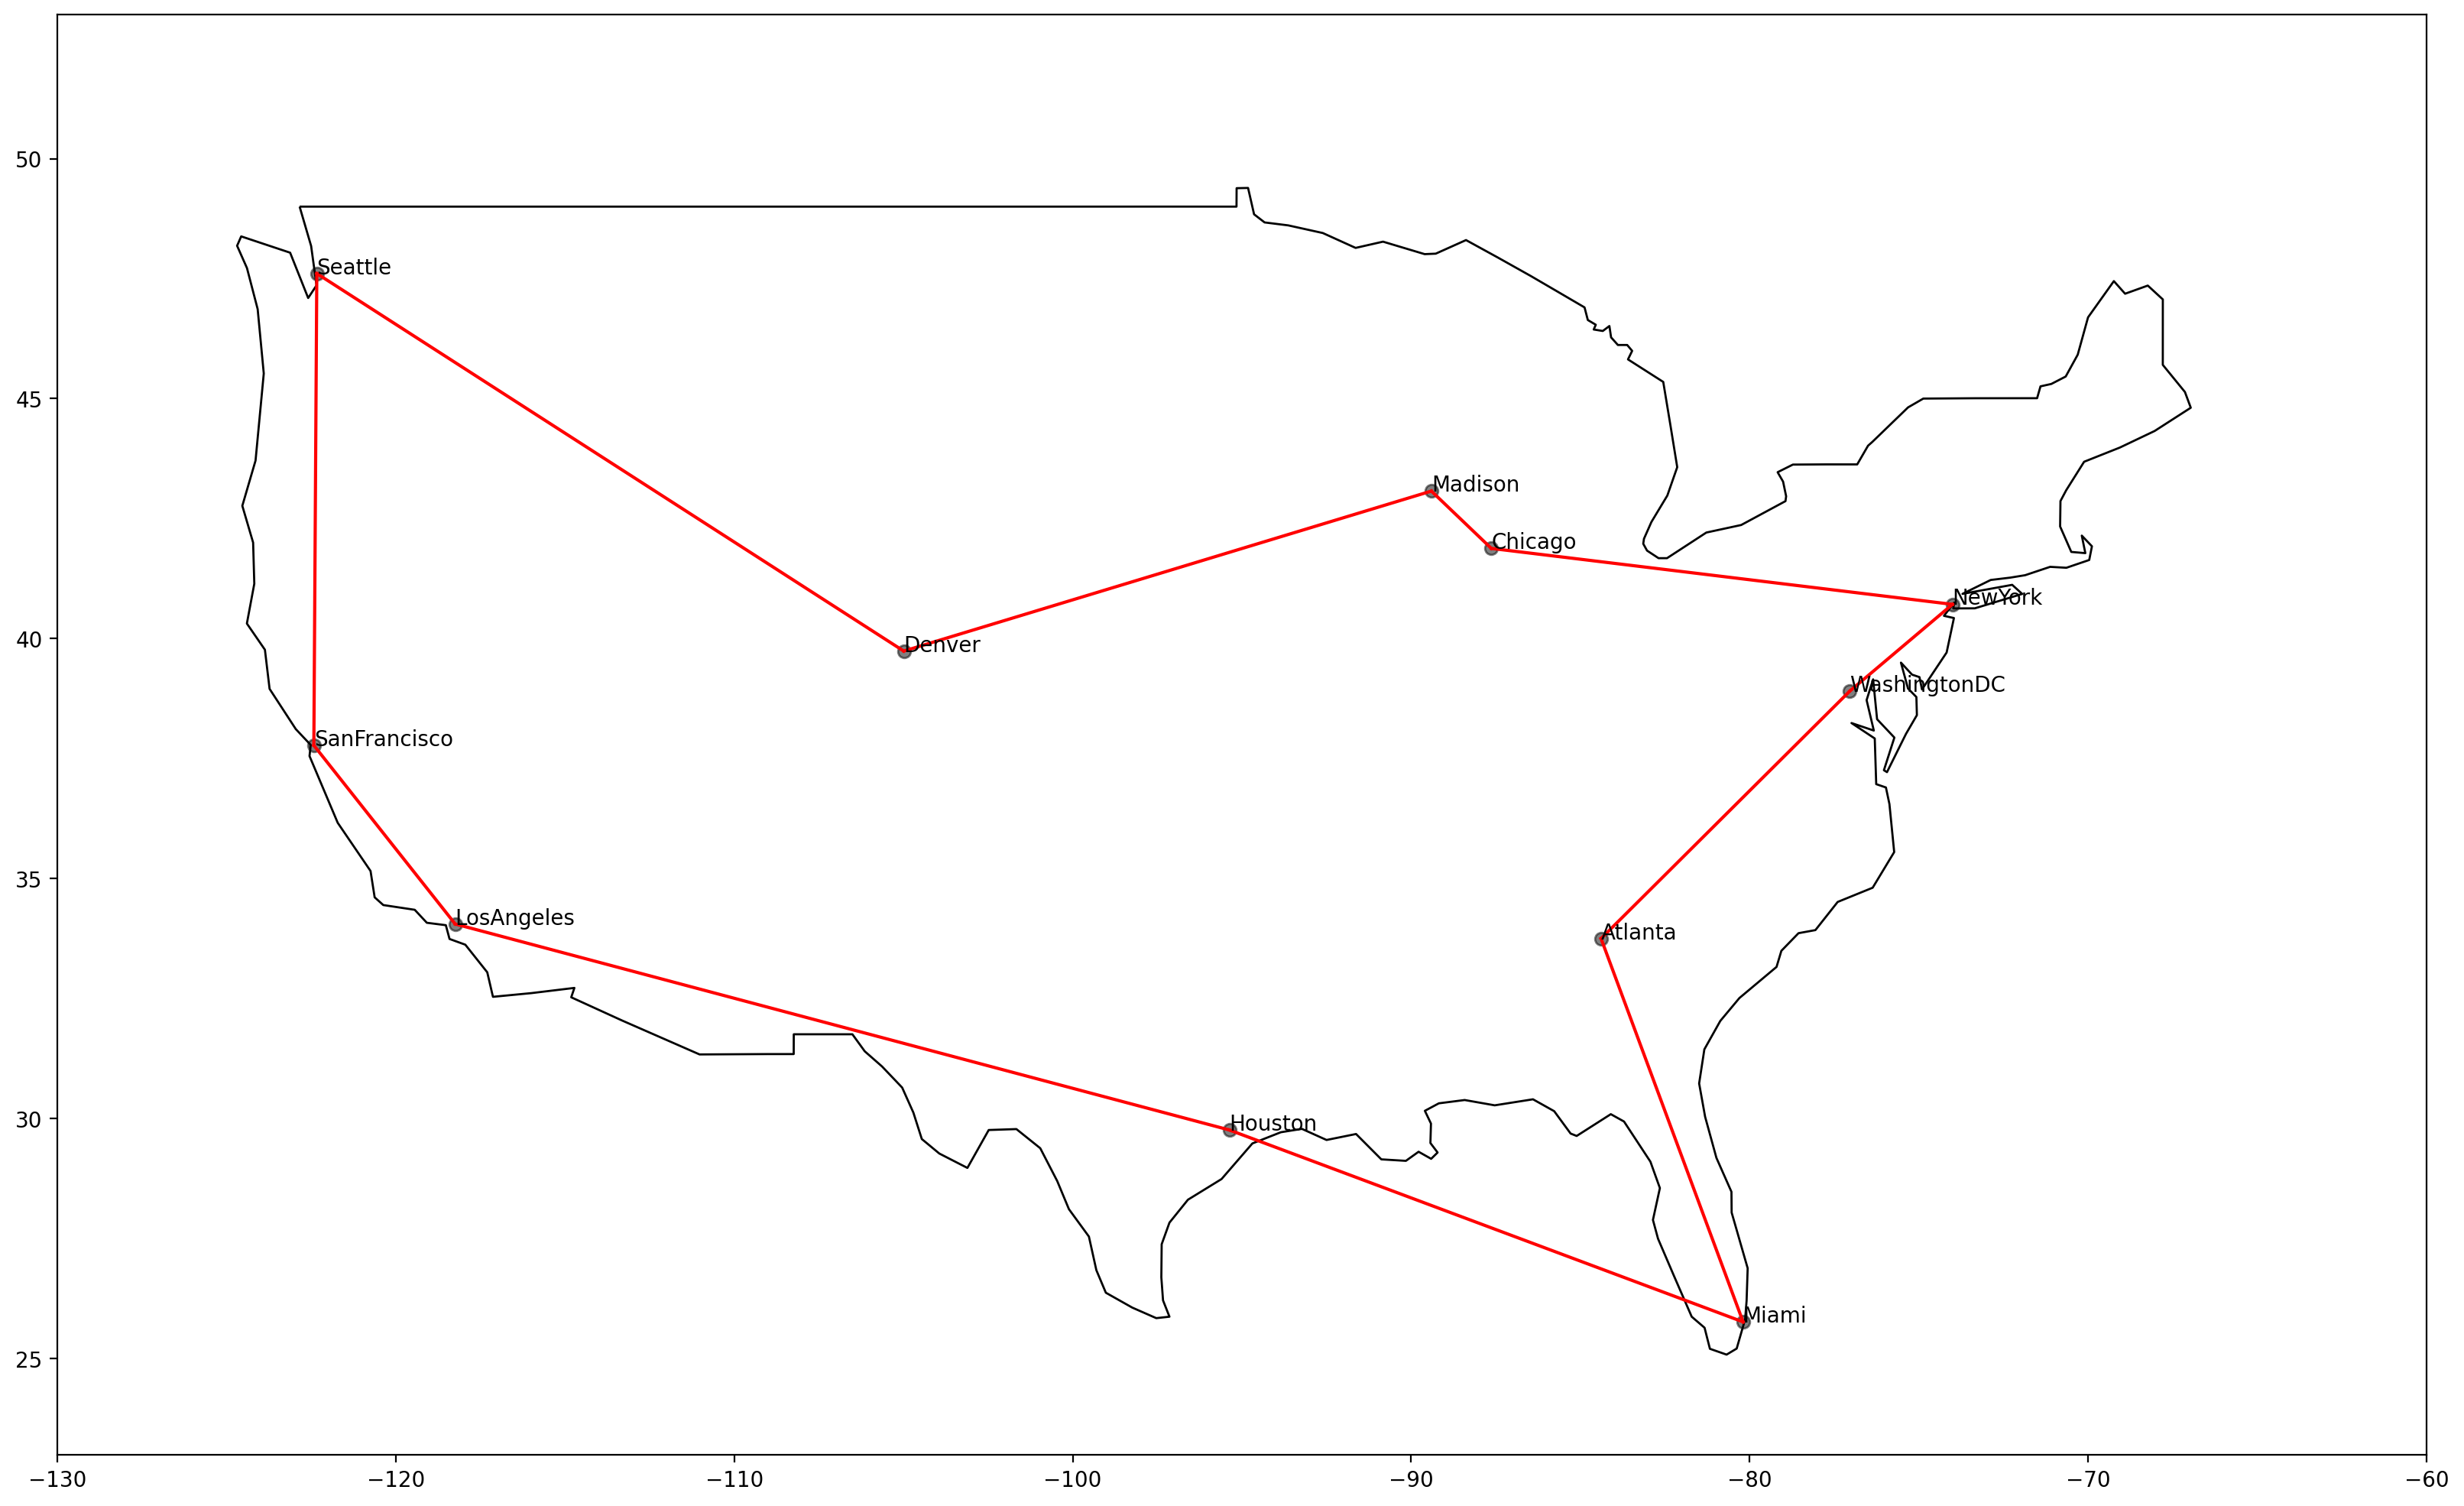

In [11]:
tour = t.records[t.domain_labels].copy()
plot_with_tour(tour)

Finally, we successfully solved the TSP problem!

### Summary of TSP Problem

- How do we get rid of those pesky subtours? 
- For every set S of cities except the whole set, we can use at most $|S| - 1$ edges.

$\sum_{i \in S} \sum_{j \in S} x_{ij} \le |S|-1 \space\space\space  \forall S \subseteq N, 2 \le |S| \le |N|- 1 $

- There are exponentially many “subtour elimination” constraints

For example:

- If we want to eliminate tours of only two cities, then number of constraints are the number of edges joining two cities with is $|N|$ choose 2.

- If we have three city subtours, then we choose 3 cities so the number of riangle constraints is $|N|$ choose 3 which $= (|N|(|N|-1)(|N|-2)/6$

- When we have four cities, the number of constraints that need to be eliminated will be huge, even for relatively small $|N|$.


## Example: Miller Tucker Zemlin

- There is a weaker, but more compact formulation that should suffice to eliminate subtours for smallish instances.

- The example is derived from the "Turn on Constraint".

- Idea: Let $u_{i}$, $i \in N$ be the relative positive of node $i$ in the tour. 
Choose node 1 to be first (arbitrarily) $u_1 = 1$.

- $2 \leq u_{i} \leq n = |N| \space\space\space\space \forall i \in N\setminus \{ 1 \}$
- Just model implication (assuming $x_{ii} = 0$ is forced):
    $x_{ij} = 1 \Rightarrow u_{j} \geq u_{i} + 1(i.e.u_{i} - u_{j} + 1 \leq 0) \forall i \neq 1, \forall j \neq 1)$
    
    $δ=1⇒ g(x) ≤ 0 ⇔ g(x) ≤ M(1-δ)$
- $M = n-2+1 = n-1$
- Gives inequalities
$u_{i} - u_{j} + 1 ≤ (n - 1)(1- x_{ij} ), ∀i \neq 1, ∀j \neq 1.$

More Explanation:
- $u_{i}$ represents the relative position 
- For example: $u_{1}$ = 7 means $u_{1}$ is the 7th city visited during the tour. 
- $u_{i}$ is integer values that can be generated to represent relative position. 
- $u_{i}$ is integer value between $1$ and $N$ that indicates the order of city visited. 
- The constaint $x_{ij} = 1$ represents $u_{j} ≥ u_{i} + 1$, which means we visited $j$ after visting $i$.

These constraints are not as tight as "subtour elimination constraints", but are strong enough to generate valid tours. In this case, we can make sure we visit every city once and there is no subtours.

We call the last inequality in an arc-constraint. The formulation consisting of (1) and (2) is called the Miller-Tucker-Zemlin (MTZ) formulation of the TSP. It indeed excludes subtours, as (1) the arc-constraint for (i, j) forces $u_{j} ≥ u_{i} + 1$ when $x_{ij} = 1$; (2) if a feasible solution of (1)-(2) contained more than one subtour, then at least one of these would not contain node 1, and along this subtour the $u_{i}$ values would have to increase to infinity. This argument, with the bounds on the $u_i$ variables, also implies that the only feasible value of $u_{i}$ is the position of node $i$ in the tour.


# Reference

- [wikipedia](https://en.wikipedia.org/wiki/Travelling_salesman_problem#Integer_linear_programming_formulations): more details about Miller-Tucker-Zemlin (MTZ) formulation and the stronger Dantzig-Fulkerson-Johnson (DFJ) 
- [other solutions for TSP](https://www.geeksforgeeks.org/travelling-salesman-problem-set-1/): solve travelling salesman problems by dynamic programming

In [12]:
%gams_cleanup --closedown